# Model Performance Analysis for Shell Script Classification

This notebook analyzes the performance of different LLM models on shell script
classification tasks. Models classify scripts as PASS (no violations) or FAIL
(has environment variable violations or forbidden constructs).

## Analysis Goals

This analysis addresses three key questions:

**GOAL 1: TEST PATTERN ANALYSIS**
- Question: How do different models compare on individual tests?
- Approach: Identify which test scripts are most commonly misclassified across models

**GOAL 2: CHARACTERISTIC ANALYSIS**
- Question: What makes models accurate? What makes models fast?
- Approach: Analyze relationships between model parameters, size, quantization, and performance

**GOAL 3: BEST MODEL SELECTION**
- Question: Which model is best (most accurate, fastest to run)?
- Approach: Use Pareto frontier analysis to identify optimal speed/accuracy trade-offs

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from typing import Dict, List, Tuple, Optional
import warnings
import os

from src.config import Config

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [2]:
# This notebook is located in: notebooks/shellscript_analyzer/
# We need to navigate up to the project root
NOTEBOOK_LOCATION = Path("notebooks/shellscript_analyzer")
PROJECT_ROOT = Path.cwd().parent.parent

# Load configuration
_config = Config(PROJECT_ROOT / "config" / "config.yaml")

# Configuration constants
REPORTS_DIR = PROJECT_ROOT / _config.getReportsDir()
OUTPUT_DIR = PROJECT_ROOT / NOTEBOOK_LOCATION / "gfx"
CSV_PATTERN = "*.csv"
JPEG_DPI = 300
IMAGE_PREFIX = "shell_script_classification_"
FIGSIZE_LARGE = (16, 10)
FIGSIZE_WIDE = (20, 8)
FIGSIZE_XLARGE = (24, 12)

# Modern Color Palette
COLOR_PALETTE = {
    "primary": "#6366f1",
    "secondary": "#8b5cf6",
    "accent": "#ec4899",
    "success": "#10b981",
    "error": "#ef4444",
    "warning": "#f59e0b",
    "info": "#3b82f6",
    "false_positive": "#f87171",
    "false_negative": "#60a5fa",
    "heatmap_sequential": ["#ede9fe", "#c7d2fe", "#a5b4fc", "#818cf8", "#6366f1", "#4f46e5"],
    "heatmap_diverging": ["#ef4444", "#fca5a5", "#fef3c7", "#a7f3d0", "#34d399", "#10b981"],
    "categorical": ["#6366f1", "#8b5cf6", "#ec4899", "#f59e0b", "#10b981", "#3b82f6", "#06b6d4", "#14b8a6"],
}

# Set seaborn style
sns.set_theme(style="whitegrid")
sns.set_palette(COLOR_PALETTE["categorical"])
plt.rcParams["figure.dpi"] = 100
plt.rcParams["savefig.dpi"] = JPEG_DPI
plt.rcParams["font.size"] = 10

## Configuration

The notebook uses the following directory structure:
- **Notebook location**: `notebooks/shellscript_analyzer/`
- **Project root**: Automatically detected (two levels up from notebook location)
- **Reports directory**: `reports/` (loaded from `config.yaml`)
- **Output directory**: `notebooks/shellscript_analyzer/gfx/`

All visualizations will be saved as high-resolution JPEG images (300 DPI) with the prefix `shell_script_classification_`.

## Helper Functions

### Data Loading Functions

In [3]:
def load_model_specifications() -> Dict[str, Dict]:
    """Load model specifications from benchmark_models.json."""
    models_file = Path("benchmark_models.json")

    if not models_file.exists():
        print(f"  ⚠ Model specifications file not found: {models_file}")
        return {}

    try:
        with models_file.open(encoding="utf-8") as f:
            data = json.load(f)
        specs = {model["model_name"]: model for model in data.get("models", [])}
        print(f"  ✓ Loaded specifications for {len(specs)} models from {models_file.name}")
        return specs
    except Exception as e:
        print(f"  ⚠ Failed to load model specifications: {e}")
        return {}


def scan_csv_files(reports_dir: Path) -> List[Path]:
    """Scan the reports directory for CSV files containing model benchmarks."""
    csv_files = list(reports_dir.glob(CSV_PATTERN))
    model_csvs = [
        f for f in csv_files
        if f.stem not in ["summary", "temp", "shell_env_detector_test_results"]
    ]
    return sorted(model_csvs)


def extract_model_name(filepath: Path) -> str:
    """Extract the model name from the CSV filename."""
    return filepath.stem


def extract_timing_from_log(model_name: str, reports_dir: Path) -> int:
    """Extract total elapsed time from the model's log file."""
    log_file = reports_dir / f"{model_name}.log"
    if not log_file.exists():
        return -1
    try:
        with open(log_file, "r", encoding="utf-8") as f:
            for line in f:
                if "Total elapsed time:" in line:
                    parts = line.strip().split()
                    if len(parts) >= 4 and parts[-1] == "seconds":
                        return int(parts[-2])
    except Exception:
        return -1
    return -1


def validate_csv_format(df: pd.DataFrame, filepath: Path) -> None:
    """Validate that the CSV has the expected 5-column format."""
    expected_columns = ["Script", "Expected", "Predicted", "Match", "Error"]
    actual_columns = df.columns.tolist()

    if len(actual_columns) == 4:
        raise ValueError(
            f"ERROR: {filepath.name} uses the old 4-column format.\n"
            f"Expected columns: {expected_columns}\n"
            f"Actual columns: {actual_columns}\n\n"
            f"To convert, please:\n"
            f"1. Rename 'Actual' column to 'Predicted'\n"
            f"2. Add an 'Error' column (can be empty)\n"
            f"3. Ensure Script column contains full path to test files\n"
        )

    if actual_columns != expected_columns:
        raise ValueError(
            f"ERROR: {filepath.name} has unexpected column format.\n"
            f"Expected: {expected_columns}\n"
            f"Actual: {actual_columns}\n"
        )


def extract_script_basename(script_path: str) -> str:
    """Extract the basename from a script path."""
    return Path(script_path).name


def determine_test_type(script_name: str) -> str:
    """Determine if a test script is a 'bad' or 'good' example."""
    if script_name.startswith("bad_"):
        return "bad"
    elif script_name.startswith("good_"):
        return "good"
    else:
        return "unknown"


def load_all_models() -> Dict[str, pd.DataFrame]:
    """Load all model CSV files from the reports directory."""
    csv_files = scan_csv_files(REPORTS_DIR)

    if not csv_files:
        raise ValueError(f"No CSV files found in {REPORTS_DIR}")

    print(f"\nFound {len(csv_files)} model CSV file(s) in {REPORTS_DIR}")

    model_data = {}

    for csv_file in csv_files:
        model_name = extract_model_name(csv_file)
        df = pd.read_csv(csv_file)

        validate_csv_format(df, csv_file)

        df["script_basename"] = df["Script"].apply(extract_script_basename)
        df["test_type"] = df["script_basename"].apply(determine_test_type)

        bad_mask = df["test_type"] == "bad"
        good_mask = df["test_type"] == "good"
        df.loc[bad_mask, "test_id"] = range(bad_mask.sum())
        df.loc[good_mask, "test_id"] = range(50, 50 + good_mask.sum())
        df["test_id"] = df["test_id"].astype(int)

        model_data[model_name] = df
        print(f"  Loaded: {model_name} ({len(df)} tests)")

    first_model = list(model_data.keys())[0]
    reference_scripts = set(model_data[first_model]["script_basename"])

    for model_name, df in model_data.items():
        model_scripts = set(df["script_basename"])
        if model_scripts != reference_scripts:
            missing = reference_scripts - model_scripts
            extra = model_scripts - reference_scripts
            print(f"\nWARNING: {model_name} has different test scripts:")
            if missing:
                print(f"  Missing: {missing}")
            if extra:
                print(f"  Extra: {extra}")

    return model_data

### Metric Calculation Functions

In [4]:
def calculate_confusion_matrix_values(df: pd.DataFrame) -> Tuple[int, int, int, int]:
    """Calculate confusion matrix values for a single model."""
    tp = ((df["Expected"] == "PASS") & (df["Predicted"] == "PASS")).sum()
    tn = ((df["Expected"] == "FAIL") & (df["Predicted"] == "FAIL")).sum()
    fp = ((df["Expected"] == "FAIL") & (df["Predicted"] == "PASS")).sum()
    fn = ((df["Expected"] == "PASS") & (df["Predicted"] == "FAIL")).sum()
    return tp, tn, fp, fn


def normalize_quantization(quant: str) -> str:
    """Normalize quantization format to bit-level string."""
    if not quant or quant == "":
        return ""

    quant_upper = quant.upper()

    if quant_upper.startswith("Q4"):
        return "4bit"
    if quant_upper.startswith("Q5"):
        return "5bit"
    if quant_upper.startswith("Q6"):
        return "6bit"
    if quant_upper.startswith("Q8"):
        return "8bit"

    return quant.lower()


def calculate_metrics(model_data: Dict[str, pd.DataFrame], model_specs: Optional[Dict[str, Dict]] = None) -> pd.DataFrame:
    """Calculate performance metrics for all models."""
    if model_specs is None:
        model_specs = {}

    metrics_list = []

    for model_name, df in model_data.items():
        df_clean = df[df["Predicted"] != "ERROR"].copy()

        if len(df_clean) == 0:
            print(f"WARNING: {model_name} has no valid predictions (all ERROR)")
            continue

        tp, tn, fp, fn = calculate_confusion_matrix_values(df_clean)

        y_true = (df_clean["Expected"] == "PASS").astype(int)
        y_pred = (df_clean["Predicted"] == "PASS").astype(int)

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0.0)
        recall = recall_score(y_true, y_pred, zero_division=0.0)
        f1 = f1_score(y_true, y_pred, zero_division=0.0)

        time_seconds = extract_timing_from_log(model_name, REPORTS_DIR)

        specs = model_specs.get(model_name, {})
        params_b = specs.get("params_billions")
        size_gb = specs.get("size_gb")
        quantization = specs.get("quantization")
        if quantization:
            quantization = normalize_quantization(quantization)

        metrics_list.append(
            {
                "Model": model_name,
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_Score": f1,
                "TP": tp,
                "TN": tn,
                "FP": fp,
                "FN": fn,
                "Total": len(df_clean),
                "Time_s": time_seconds,
                "Params_B": params_b if params_b is not None else "",
                "Size_GB": size_gb if size_gb is not None else "",
                "Quantization": quantization if quantization else "",
            }
        )

    metrics_df = pd.DataFrame(metrics_list)
    metrics_df = metrics_df.sort_values("F1_Score", ascending=False).reset_index(drop=True)

    return metrics_df


def format_time_mmss(seconds: float) -> str:
    """Format seconds as mm:ss string."""
    minutes = int(seconds // 60)
    secs = int(seconds % 60)
    return f"{minutes}:{secs:02d}"


def calculate_pareto_front(metrics_df: pd.DataFrame) -> List[str]:
    """Identify models on the Pareto frontier for speed vs accuracy."""
    df = metrics_df[metrics_df["Time_s"] > 0].copy()

    if len(df) == 0:
        return []

    pareto_models = []

    for i, row in df.iterrows():
        is_dominated = False
        for j, other_row in df.iterrows():
            if i != j:
                if other_row["Time_s"] < row["Time_s"] and other_row["F1_Score"] > row["F1_Score"]:
                    is_dominated = True
                    break

        if not is_dominated:
            pareto_models.append(row["Model"])

    return pareto_models

## Setup

Setting up the analysis environment and output directory.

In [5]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

## Load Data

Loading model benchmark results and specifications.

In [6]:
model_data = load_all_models()
model_specs = load_model_specifications()


Found 10 model CSV file(s) in /Users/flo/Developer/github/agentic-news-generator.git/main/reports
  Loaded: deepseek_deepseek-r1-0528-qwen3-8b (100 tests)
  Loaded: glm-4-32b-0414 (100 tests)
  Loaded: google_gemma-3-27b (100 tests)
  Loaded: mistral-small-3.2-24b-instruct-2506-mlx@4bit (100 tests)
  Loaded: mistral-small-3.2-24b-instruct-2506-mlx@6bit (100 tests)
  Loaded: mistralai_devstral-small-2-2512 (100 tests)
  Loaded: nvidia_nemotron-3-nano (100 tests)
  Loaded: qwen2.5-7b-instruct-mlx (100 tests)
  Loaded: qwen3-30b-a3b-thinking-2507-mlx@6bit (100 tests)
  Loaded: qwen_qwen3-coder-30b (100 tests)
  ✓ Loaded specifications for 27 models from benchmark_models.json


## Calculate and Display Per-Model Metrics

Calculating accuracy, precision, recall, and F1 scores for all models.

In [7]:
metrics_df = calculate_metrics(model_data, model_specs)

In [8]:
print("Performance Summary (Ranked by F1 Score)")
print("=" * 80)
print(metrics_df.to_string(index=False))

Performance Summary (Ranked by F1 Score)
                                       Model  Accuracy  Precision  Recall  F1_Score  TP  TN  FP  FN  Total  Time_s Params_B Size_GB Quantization
        qwen3-30b-a3b-thinking-2507-mlx@6bit  0.980000   0.980000    0.98  0.980000  49  49   1   1    100    4687     30.0   24.82         6bit
mistral-small-3.2-24b-instruct-2506-mlx@4bit  0.970000   0.960784    0.98  0.970297  49  48   2   1    100     247     24.0   13.54         4bit
mistral-small-3.2-24b-instruct-2506-mlx@6bit  0.970000   0.979592    0.96  0.969697  48  49   1   2    100     510     24.0   20.03         6bit
                              glm-4-32b-0414  0.960000   0.979167    0.94  0.959184  47  49   1   3    100     679     32.0   36.66         8bit
                      nvidia_nemotron-3-nano  0.940000   0.923077    0.96  0.941176  48  46   4   2    100    1491                              
                        qwen_qwen3-coder-30b  0.930000   0.905660    0.96  0.932039  48  

## Generate Visualizations

Creating comprehensive visualizations to analyze model performance.

### Visualization 1: Confusion Matrices

**ERROR ANALYSIS**

**Question:** What types of errors do models make?

Confusion matrices show the distribution of True Positives, True Negatives,
False Positives, and False Negatives for each model.

Generating Visualization 1: Confusion Matrices...


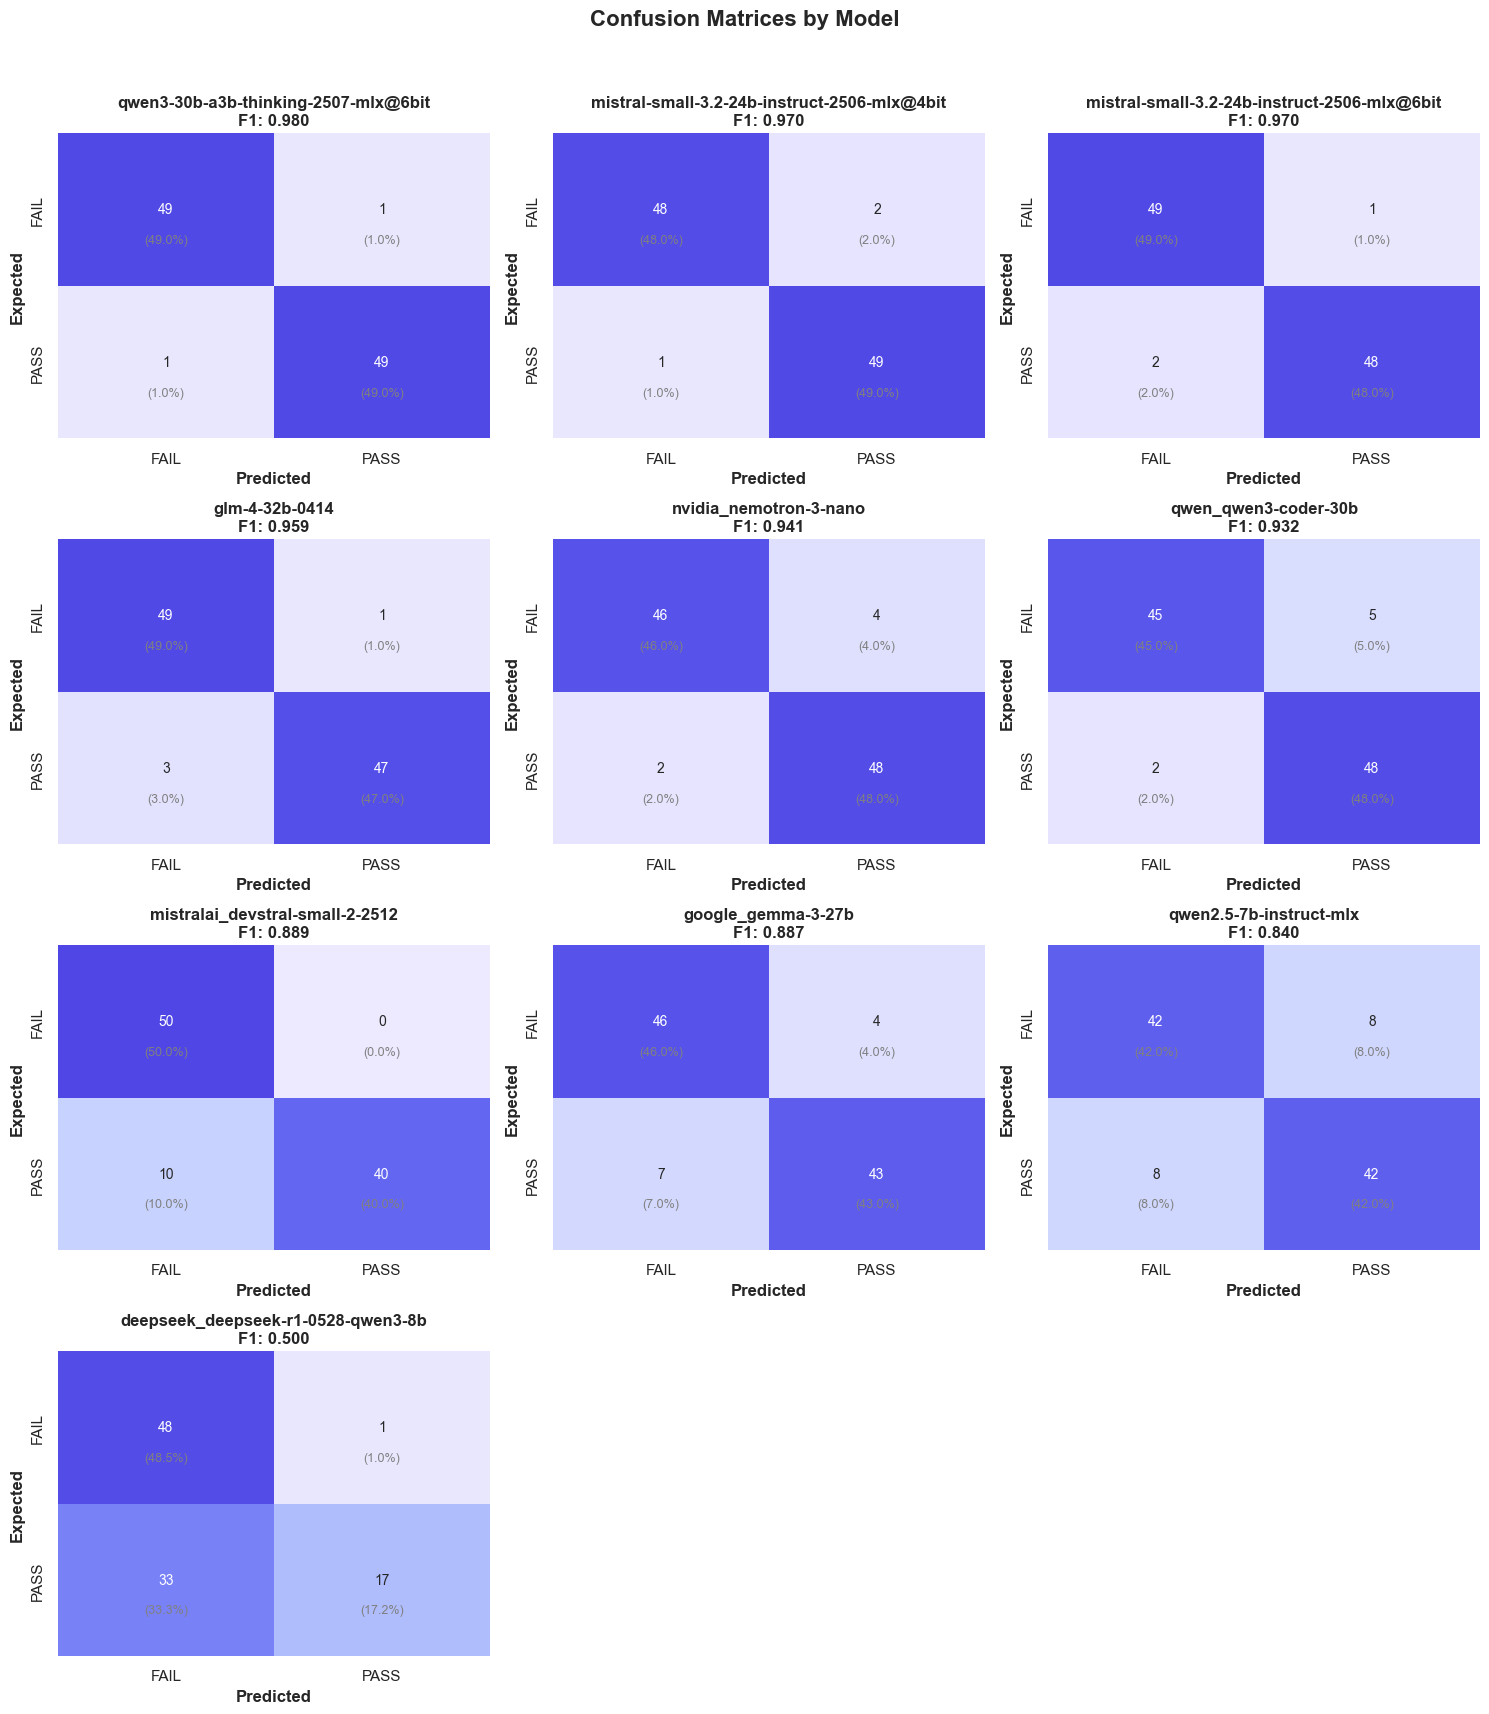

  ✓ Saved: shell_script_classification_01_confusion_matrices_grid.jpg


In [9]:
print("Generating Visualization 1: Confusion Matrices...")

model_order = metrics_df["Model"].tolist()
n_models = len(model_order)

n_cols = min(3, n_models)
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4.5))
if n_models == 1:
    axes = np.array([axes])
axes = axes.flatten()

max_count = 0
for model_name in model_order:
    df = model_data[model_name]
    df_clean = df[df["Predicted"] != "ERROR"]
    tp, tn, fp, fn = calculate_confusion_matrix_values(df_clean)
    max_count = max(max_count, tp, tn, fp, fn)

for idx, model_name in enumerate(model_order):
    ax = axes[idx]
    df = model_data[model_name]
    df_clean = df[df["Predicted"] != "ERROR"]

    tp, tn, fp, fn = calculate_confusion_matrix_values(df_clean)
    cm = np.array([[tn, fp], [fn, tp]])

    f1 = metrics_df[metrics_df["Model"] == model_name]["F1_Score"].values[0]

    from matplotlib.colors import LinearSegmentedColormap
    cmap = LinearSegmentedColormap.from_list("custom", COLOR_PALETTE["heatmap_sequential"])

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap=cmap,
        cbar=False,
        ax=ax,
        vmin=0,
        vmax=max_count,
        xticklabels=["FAIL", "PASS"],
        yticklabels=["FAIL", "PASS"],
    )

    total = cm.sum()
    for i in range(2):
        for j in range(2):
            pct = (cm[i, j] / total) * 100
            ax.text(
                j + 0.5,
                i + 0.7,
                f"({pct:.1f}%)",
                ha="center",
                va="center",
                fontsize=9,
                color="gray",
            )

    ax.set_xlabel("Predicted", fontweight="bold")
    ax.set_ylabel("Expected", fontweight="bold")
    ax.set_title(f"{model_name}\nF1: {f1:.3f}", fontweight="bold")

for idx in range(n_models, len(axes)):
    axes[idx].axis("off")

plt.suptitle("Confusion Matrices by Model", fontsize=16, fontweight="bold", y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}01_confusion_matrices_grid.jpg"
plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
plt.show()
plt.close()
print(f"  ✓ Saved: {output_path.name}")

### Visualization 2: Misclassification Analysis

**TEST PATTERN ANALYSIS**

**Question:** How do different models compare on individual tests?

This visualization identifies which specific test scripts are most commonly
misclassified across all models, revealing patterns in test difficulty.

Generating Visualization 2: Misclassification Analysis...


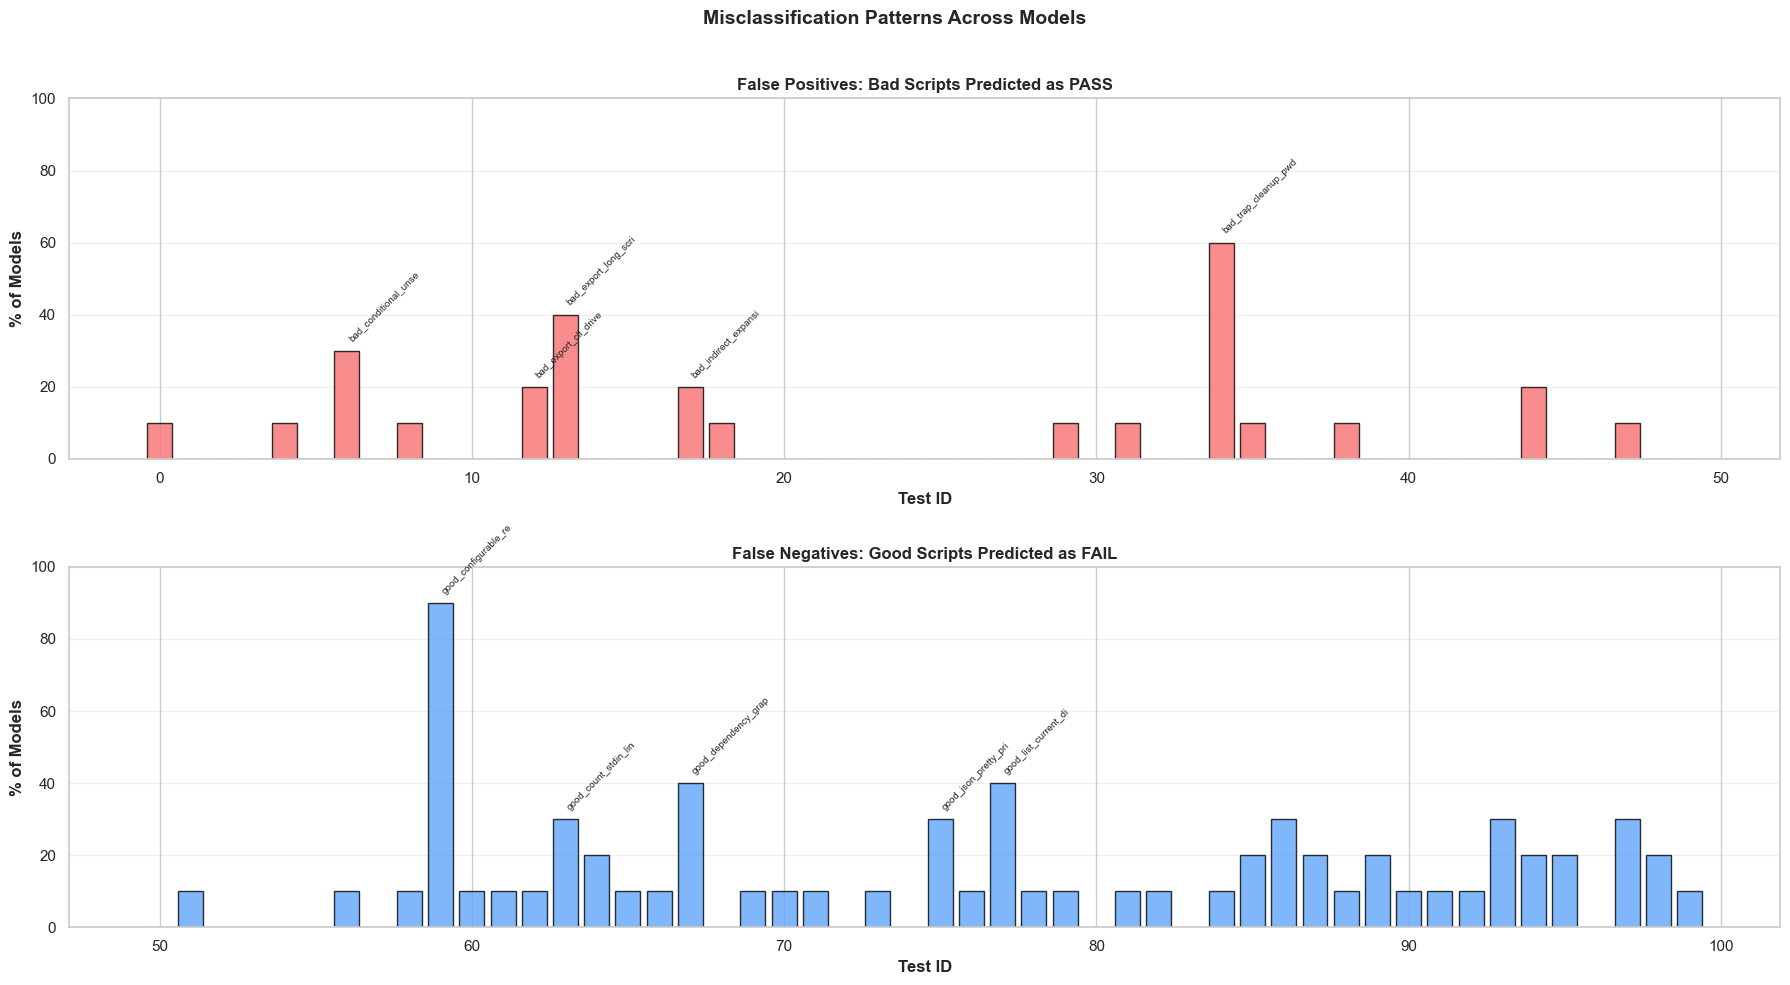

  ✓ Saved: shell_script_classification_02_misclassification_by_test.jpg


In [10]:
print("Generating Visualization 2: Misclassification Analysis...")

all_data = []
for model_name, df in model_data.items():
    df_copy = df.copy()
    df_copy["model"] = model_name
    df_copy["misclassified"] = df_copy["Match"] == "N"
    all_data.append(df_copy)

combined_df = pd.concat(all_data, ignore_index=True)

n_models = len(model_data)
misclass_counts = (
    combined_df.groupby(["test_id", "script_basename", "test_type", "Expected"])[
        "misclassified"
    ]
    .sum()
    .reset_index()
)
misclass_counts.columns = [
    "test_id",
    "script_basename",
    "test_type",
    "expected",
    "misclass_count",
]

misclass_counts["misclass_pct"] = (
    misclass_counts["misclass_count"] / n_models
) * 100

fail_tests = misclass_counts[misclass_counts["test_type"] == "bad"].copy()
pass_tests = misclass_counts[misclass_counts["test_type"] == "good"].copy()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))

if not fail_tests.empty:
    ax1.bar(
        fail_tests["test_id"],
        fail_tests["misclass_pct"],
        color=COLOR_PALETTE["false_positive"],
        alpha=0.8,
        edgecolor="black",
    )
    ax1.set_xlabel("Test ID", fontweight="bold")
    ax1.set_ylabel("% of Models", fontweight="bold")
    ax1.set_title(
        "False Positives: Bad Scripts Predicted as PASS", fontweight="bold"
    )
    ax1.set_ylim(0, 100)
    ax1.grid(axis="y", alpha=0.3)

    top5_fail = fail_tests.nlargest(5, "misclass_pct")
    for _, row in top5_fail.iterrows():
        ax1.text(
            row["test_id"],
            row["misclass_pct"] + 2,
            row["script_basename"][:20],
            rotation=45,
            ha="left",
            va="bottom",
            fontsize=7,
        )

if not pass_tests.empty:
    ax2.bar(
        pass_tests["test_id"],
        pass_tests["misclass_pct"],
        color=COLOR_PALETTE["false_negative"],
        alpha=0.8,
        edgecolor="black",
    )
    ax2.set_xlabel("Test ID", fontweight="bold")
    ax2.set_ylabel("% of Models", fontweight="bold")
    ax2.set_title(
        "False Negatives: Good Scripts Predicted as FAIL", fontweight="bold"
    )
    ax2.set_ylim(0, 100)
    ax2.grid(axis="y", alpha=0.3)

    top5_pass = pass_tests.nlargest(5, "misclass_pct")
    for _, row in top5_pass.iterrows():
        ax2.text(
            row["test_id"],
            row["misclass_pct"] + 2,
            row["script_basename"][:20],
            rotation=45,
            ha="left",
            va="bottom",
            fontsize=7,
        )

plt.suptitle(
    "Misclassification Patterns Across Models", fontsize=14, fontweight="bold"
)
plt.tight_layout(rect=[0, 0, 1, 0.96])

output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}02_misclassification_by_test.jpg"
plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
plt.show()
plt.close()
print(f"  ✓ Saved: {output_path.name}")

### Visualization 3: Model-Test Agreement Heatmaps

Visual matrix showing which models correctly classify which tests. Green cells
indicate correct predictions, red cells indicate errors.

  Generating Model-Test Agreement: FAIL Tests (bad_*.sh)...


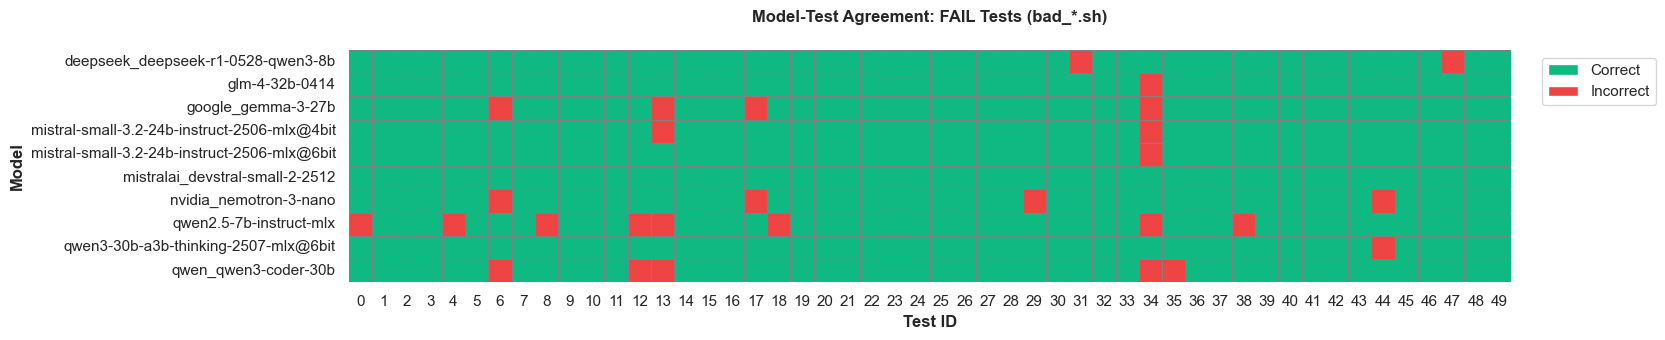

  ✓ Saved: shell_script_classification_03a_heatmap_fail_tests.jpg
  Generating Model-Test Agreement: PASS Tests (good_*.sh)...


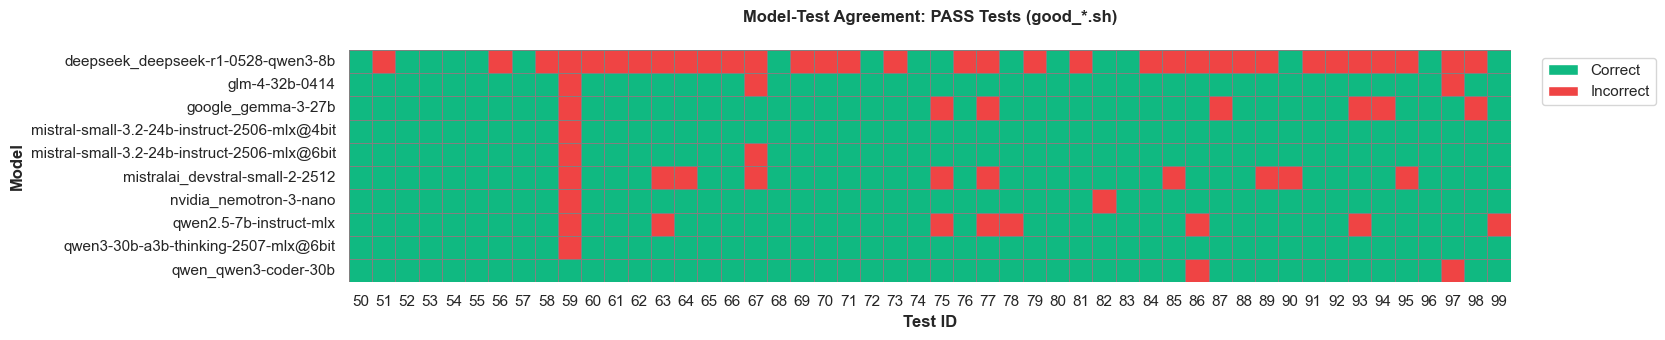

  ✓ Saved: shell_script_classification_03b_heatmap_pass_tests.jpg


In [11]:
models = sorted(model_data.keys())
first_model_df = model_data[models[0]]

fail_tests = first_model_df[first_model_df["test_type"] == "bad"].sort_values("test_id")
pass_tests = first_model_df[first_model_df["test_type"] == "good"].sort_values("test_id")


def create_heatmap(test_subset: pd.DataFrame, title: str, filename: str) -> None:
    """Helper function to create a single heatmap"""
    print(f"  Generating {title}...")
    matrix = []
    for model_name in models:
        df = model_data[model_name]
        test_basenames = test_subset["script_basename"].tolist()
        model_tests = df[df["script_basename"].isin(test_basenames)].sort_values("test_id")
        row = [1 if m == "Y" else 0 for m in model_tests["Match"]]
        matrix.append(row)

    matrix = np.array(matrix)

    n_models = len(models)
    n_tests = len(test_subset)
    cell_size = 0.35
    fig_width = n_tests * cell_size
    fig_height = n_models * cell_size
    fig_width = max(fig_width, 12)
    fig_height = max(fig_height, 3)

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    sns.heatmap(
        matrix,
        cmap=[COLOR_PALETTE["error"], COLOR_PALETTE["success"]],
        cbar=False,
        ax=ax,
        linewidths=0.5,
        linecolor="gray",
        xticklabels=test_subset["test_id"].tolist(),
        yticklabels=models,
        square=True,
    )

    ax.set_xlabel("Test ID", fontweight="bold")
    ax.set_ylabel("Model", fontweight="bold")
    ax.set_title(title, fontweight="bold", pad=20)

    from matplotlib.patches import Patch

    legend_elements = [
        Patch(facecolor=COLOR_PALETTE["success"], label="Correct"),
        Patch(facecolor=COLOR_PALETTE["error"], label="Incorrect"),
    ]
    ax.legend(
        handles=legend_elements, loc="upper left", bbox_to_anchor=(1.02, 1), ncol=1
    )

    plt.tight_layout()

    output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}{filename}"
    plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
    plt.show()
    plt.close()
    print(f"  ✓ Saved: {output_path.name}")


create_heatmap(
    fail_tests,
    "Model-Test Agreement: FAIL Tests (bad_*.sh)",
    "03a_heatmap_fail_tests.jpg",
)
create_heatmap(
    pass_tests,
    "Model-Test Agreement: PASS Tests (good_*.sh)",
    "03b_heatmap_pass_tests.jpg",
)

### Understanding the Pareto Frontier

The **Pareto frontier** (or Pareto front) represents the set of optimal trade-offs
between two competing objectives. In our case, these objectives are:
- **Speed**: Faster execution time (lower is better)
- **Accuracy**: Higher F1 score (higher is better)

A model is on the Pareto frontier if no other model is both faster AND more accurate.
In other words, to get better accuracy, you must accept slower speed, and vice versa.

Models on the Pareto front are marked with **stars (★)** in the visualization below.

### Visualization 4: Efficiency Scatter Plot

**BEST MODEL SELECTION: SPEED VS ACCURACY TRADE-OFF**

**Question:** Which model is best (most accurate, fastest to run)?

This scatter plot shows the Pareto frontier - models that achieve the best
balance between speed and accuracy. Stars indicate models on the Pareto front.

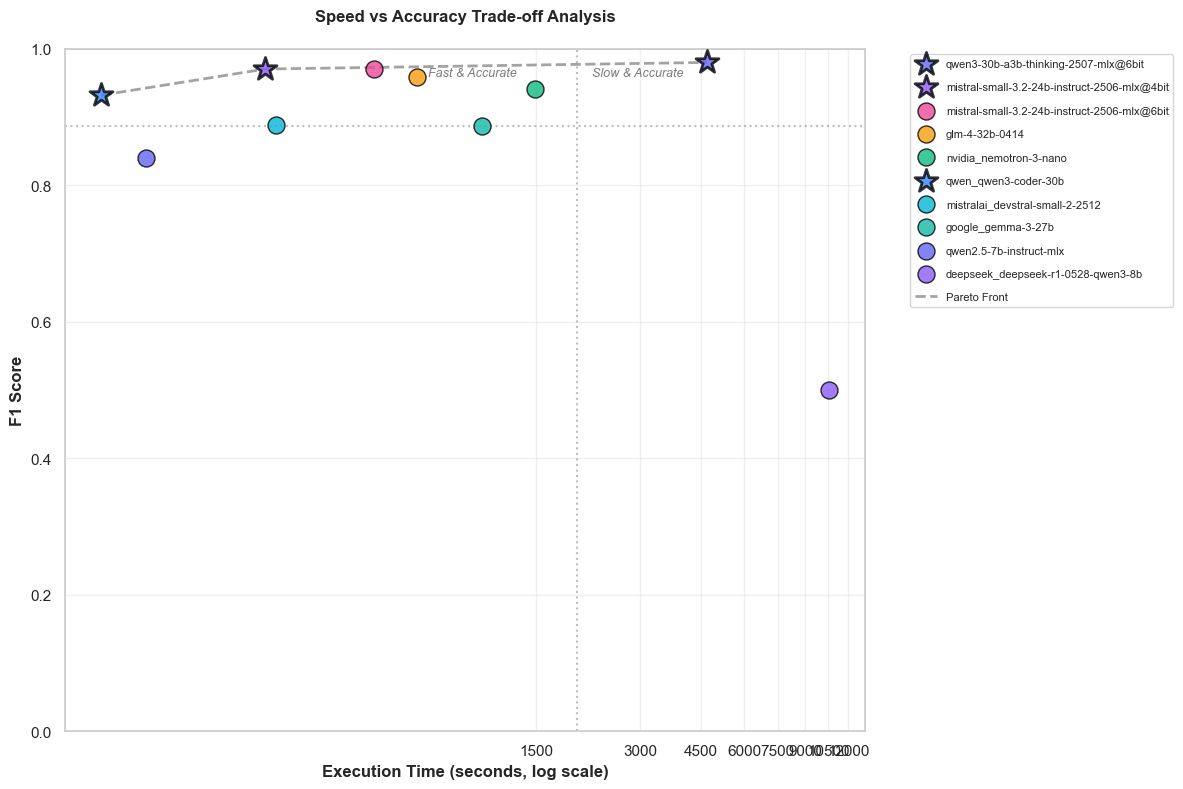

  ✓ Saved: shell_script_classification_04_efficiency_scatter.jpg


In [12]:
df = metrics_df[metrics_df["Time_s"] > 0].copy()
pareto_models = calculate_pareto_front(df)

if len(df) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))

    for idx, row in df.iterrows():
        is_pareto = row["Model"] in pareto_models
        marker = "*" if is_pareto else "o"
        size = 300 if is_pareto else 150

        ax.scatter(
            row["Time_s"],
            row["F1_Score"],
            s=size,
            marker=marker,
            color=COLOR_PALETTE["categorical"][idx % len(COLOR_PALETTE["categorical"])],
            edgecolors="black",
            linewidth=2 if is_pareto else 1,
            alpha=0.8,
            label=row["Model"],
            zorder=10 if is_pareto else 5
        )

    pareto_df = df[df["Model"].isin(pareto_models)].sort_values("Time_s")
    if len(pareto_df) > 1:
        ax.plot(
            pareto_df["Time_s"],
            pareto_df["F1_Score"],
            "k--",
            alpha=0.4,
            linewidth=2,
            label="Pareto Front"
        )

    mean_time = df["Time_s"].mean()
    mean_f1 = df["F1_Score"].mean()

    ax.axvline(mean_time, color="gray", linestyle=":", alpha=0.5)
    ax.axhline(mean_f1, color="gray", linestyle=":", alpha=0.5)

    ax.text(mean_time * 0.5, df["F1_Score"].max() * 0.98,
            "Fast & Accurate", ha="center", fontsize=9, style="italic", alpha=0.6)
    ax.text(mean_time * 1.5, df["F1_Score"].max() * 0.98,
            "Slow & Accurate", ha="center", fontsize=9, style="italic", alpha=0.6)

    ax.set_xlabel("Execution Time (seconds)", fontweight="bold")
    ax.set_ylabel("F1 Score", fontweight="bold")
    ax.set_title("Speed vs Accuracy Trade-off Analysis", fontweight="bold", pad=20)

    # Set y-axis to start from 0
    ax.set_ylim(bottom=0, top=1.0)

    # Set x-axis to show full numbers without scientific notation
    from matplotlib.ticker import ScalarFormatter, MaxNLocator
    if df["Time_s"].max() / df["Time_s"].min() > 10:
        ax.set_xscale("log")
        ax.set_xlabel("Execution Time (seconds, log scale)", fontweight="bold")
    # Format x-axis to show full numbers
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10, integer=False))
    formatter = ScalarFormatter(useOffset=False)
    formatter.set_scientific(False)
    ax.xaxis.set_major_formatter(formatter)

    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8, labelspacing=1.2)
    ax.grid(alpha=0.3)

    plt.tight_layout()

    output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}04_efficiency_scatter.jpg"
    plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
    plt.show()
    plt.close()
    print(f"  ✓ Saved: {output_path.name}")
else:
    print("  ⚠ Skipping efficiency scatter - no timing data available")

### Visualization 5: Performance vs Model Characteristics

**CHARACTERISTIC ANALYSIS: WHAT MAKES MODELS ACCURATE?**

**Question:** How does parameter count impact performance?

These scatter plots analyze the relationship between model size (both in
parameters and disk space) and classification accuracy, colored by quantization level.

Generating Visualization 5a: Performance vs Model Parameters...


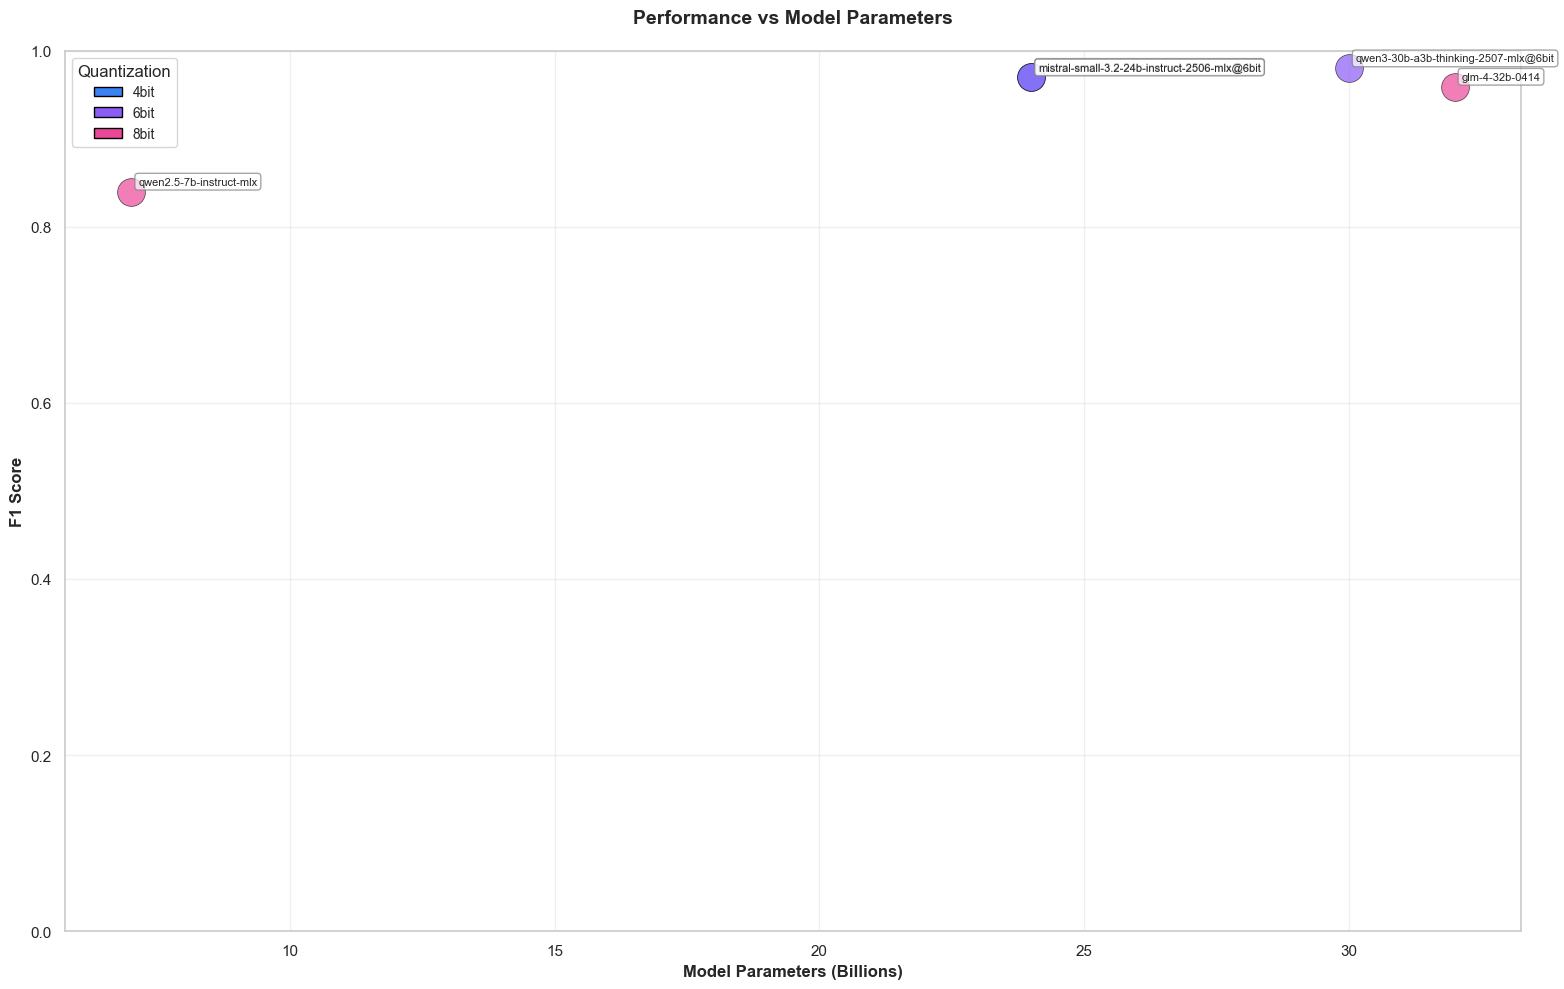

  ✓ Saved: shell_script_classification_05a_performance_vs_params.jpg
Generating Visualization 5b: Performance vs Model Size...


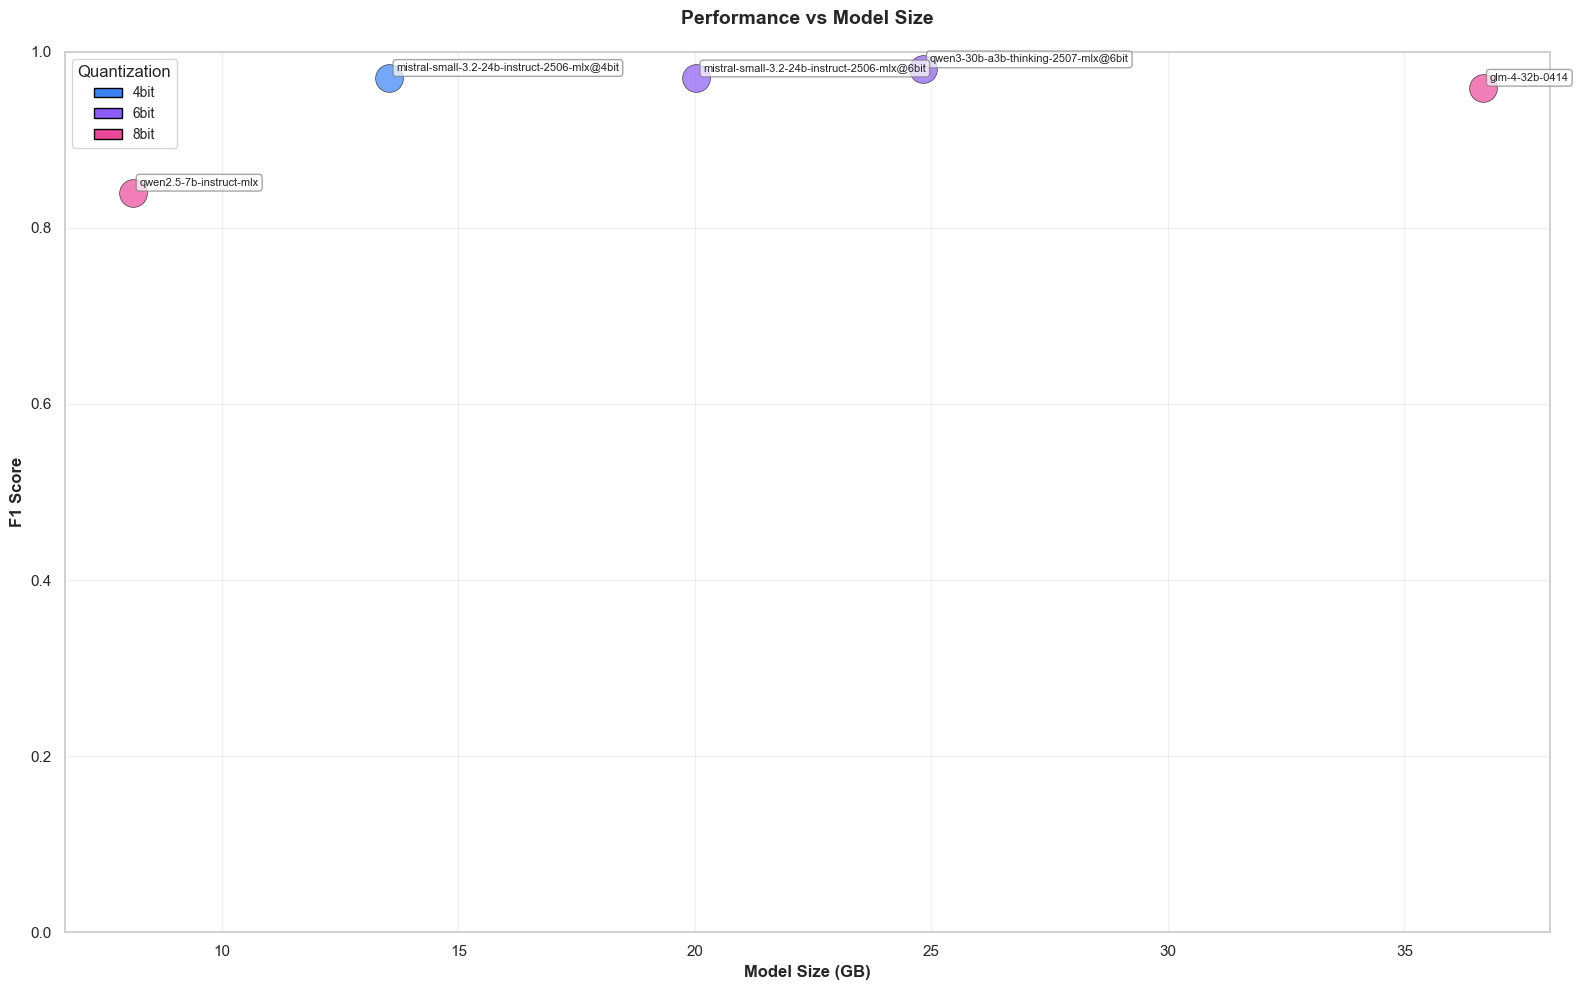

  ✓ Saved: shell_script_classification_05b_performance_vs_size.jpg


In [13]:
if (metrics_df["Params_B"] != "").any():
    print("Generating Visualization 5a: Performance vs Model Parameters...")

    df = metrics_df[
        (metrics_df["Params_B"] != "") &
        (metrics_df["Quantization"] != "")
    ].copy()

    if len(df) >= 2:
        df["Params_B"] = pd.to_numeric(df["Params_B"])

        quant_colors = {
            "4bit": "#3b82f6",
            "6bit": "#8b5cf6",
            "8bit": "#ec4899",
        }

        fig, ax = plt.subplots(figsize=FIGSIZE_LARGE)

        for quant in sorted(df["Quantization"].unique()):
            subset = df[df["Quantization"] == quant]
            ax.scatter(
                subset["Params_B"],
                subset["F1_Score"],
                s=400,
                color=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                alpha=0.7,
                edgecolors="black",
                linewidth=0.5,
                label=quant
            )

        for _, row in df.iterrows():
            ax.annotate(
                row["Model"],
                (row["Params_B"], row["F1_Score"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray")
            )

        ax.set_xlabel("Model Parameters (Billions)", fontweight="bold", fontsize=12)
        ax.set_ylabel("F1 Score", fontweight="bold", fontsize=12)
        ax.set_title("Performance vs Model Parameters", fontweight="bold", fontsize=14, pad=20)
        ax.set_ylim(0, 1.0)
        ax.grid(alpha=0.3)

        # Create custom legend with rectangles instead of circles
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                  edgecolor='black', linewidth=1, label=quant)
            for quant in sorted(df["Quantization"].unique())
        ]
        ax.legend(handles=legend_elements, title="Quantization", loc="best", fontsize=10)

        plt.tight_layout()

        output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}05a_performance_vs_params.jpg"
        plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
        plt.show()
        plt.close()
        print(f"  ✓ Saved: {output_path.name}")

        # Visualization 5b: Performance vs Size
        print("Generating Visualization 5b: Performance vs Model Size...")

        df = metrics_df[
            (metrics_df["Size_GB"] != "") &
            (metrics_df["Quantization"] != "")
        ].copy()

        if len(df) >= 2:
            df["Size_GB"] = pd.to_numeric(df["Size_GB"])

            fig, ax = plt.subplots(figsize=FIGSIZE_LARGE)

            for quant in sorted(df["Quantization"].unique()):
                subset = df[df["Quantization"] == quant]
                ax.scatter(
                    subset["Size_GB"],
                    subset["F1_Score"],
                    s=400,
                    color=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                    alpha=0.7,
                    edgecolors="black",
                    linewidth=0.5,
                    label=quant
                )

            for _, row in df.iterrows():
                ax.annotate(
                    row["Model"],
                    (row["Size_GB"], row["F1_Score"]),
                    xytext=(5, 5),
                    textcoords="offset points",
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray")
                )

            ax.set_xlabel("Model Size (GB)", fontweight="bold", fontsize=12)
            ax.set_ylabel("F1 Score", fontweight="bold", fontsize=12)
            ax.set_title("Performance vs Model Size", fontweight="bold", fontsize=14, pad=20)
            ax.set_ylim(0, 1.0)
            ax.grid(alpha=0.3)

            # Create custom legend with rectangles instead of circles
            legend_elements = [
                Patch(facecolor=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                      edgecolor='black', linewidth=1, label=quant)
                for quant in sorted(df["Quantization"].unique())
            ]
            ax.legend(handles=legend_elements, title="Quantization", loc="best", fontsize=10)

            plt.tight_layout()

            output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}05b_performance_vs_size.jpg"
            plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
            plt.show()
            plt.close()
            print(f"  ✓ Saved: {output_path.name}")
        else:
            print("  ⚠ Insufficient data for size analysis")
    else:
        print("  ⚠ Insufficient data for parameter analysis")
else:
    print("\n⚠ Skipping accuracy characteristic analysis - no model spec data available")

### Visualization 6: Speed vs Model Characteristics

**WHAT MAKES MODELS FAST?**

**Question:** How do size and parameter count individually impact speed?

These scatter plots analyze the relationship between model characteristics
(parameters and disk size) and execution speed, revealing quantization's impact.

Generating Visualization 6a: Speed vs Model Parameters...


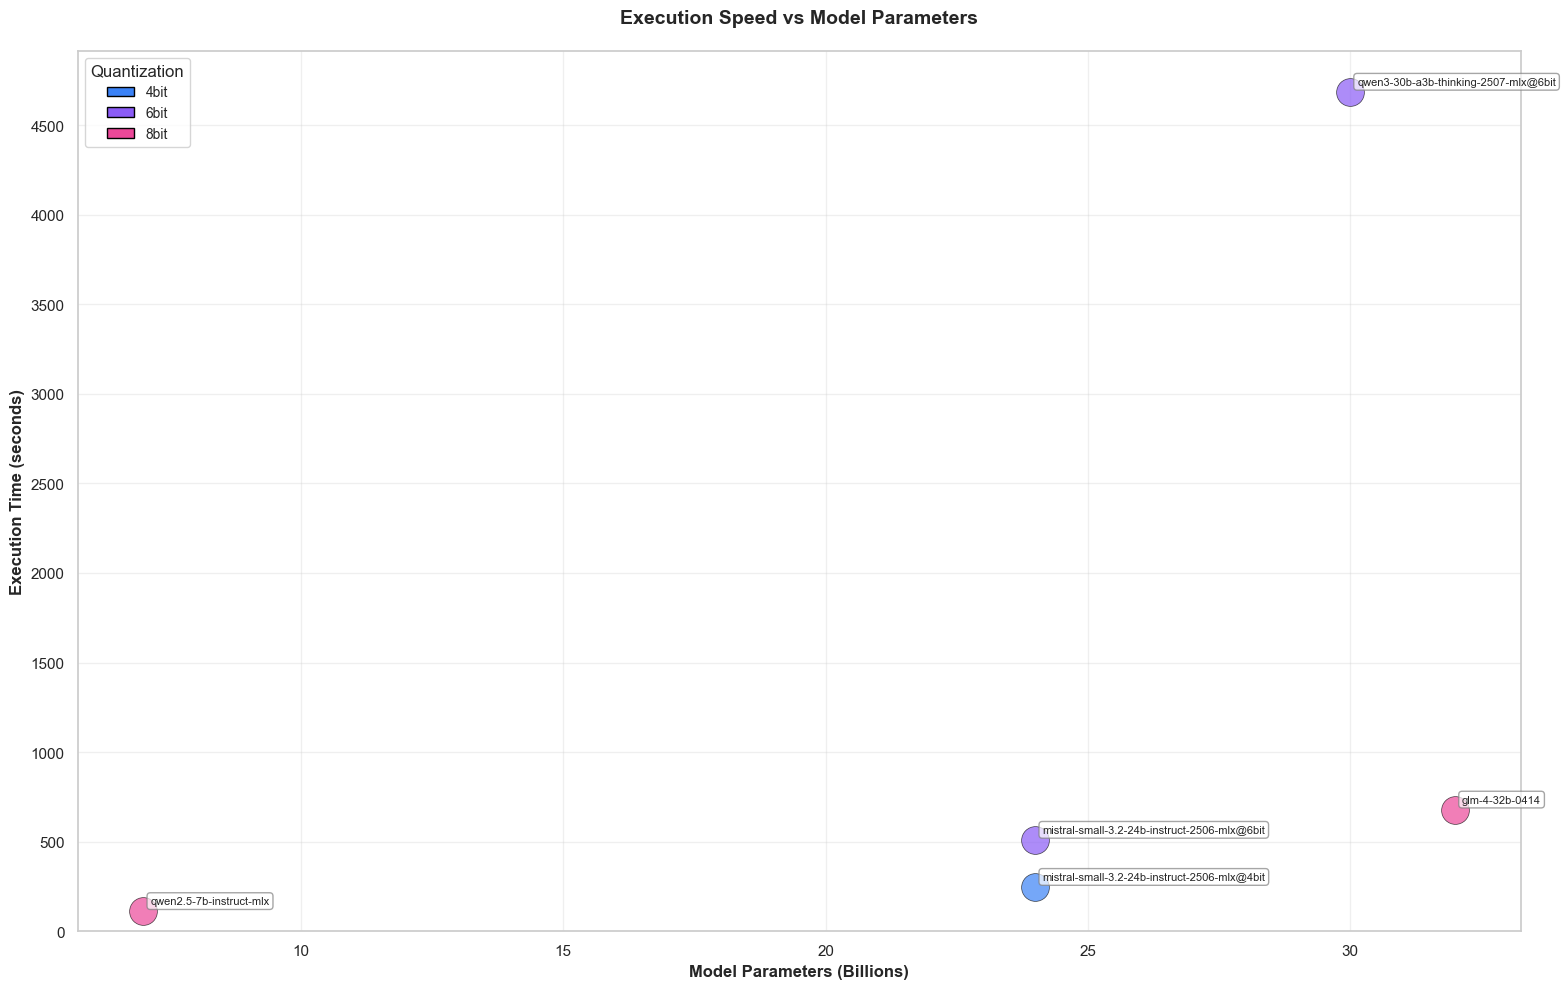

  ✓ Saved: shell_script_classification_06a_speed_vs_params.jpg
Generating Visualization 6b: Speed vs Model Size...


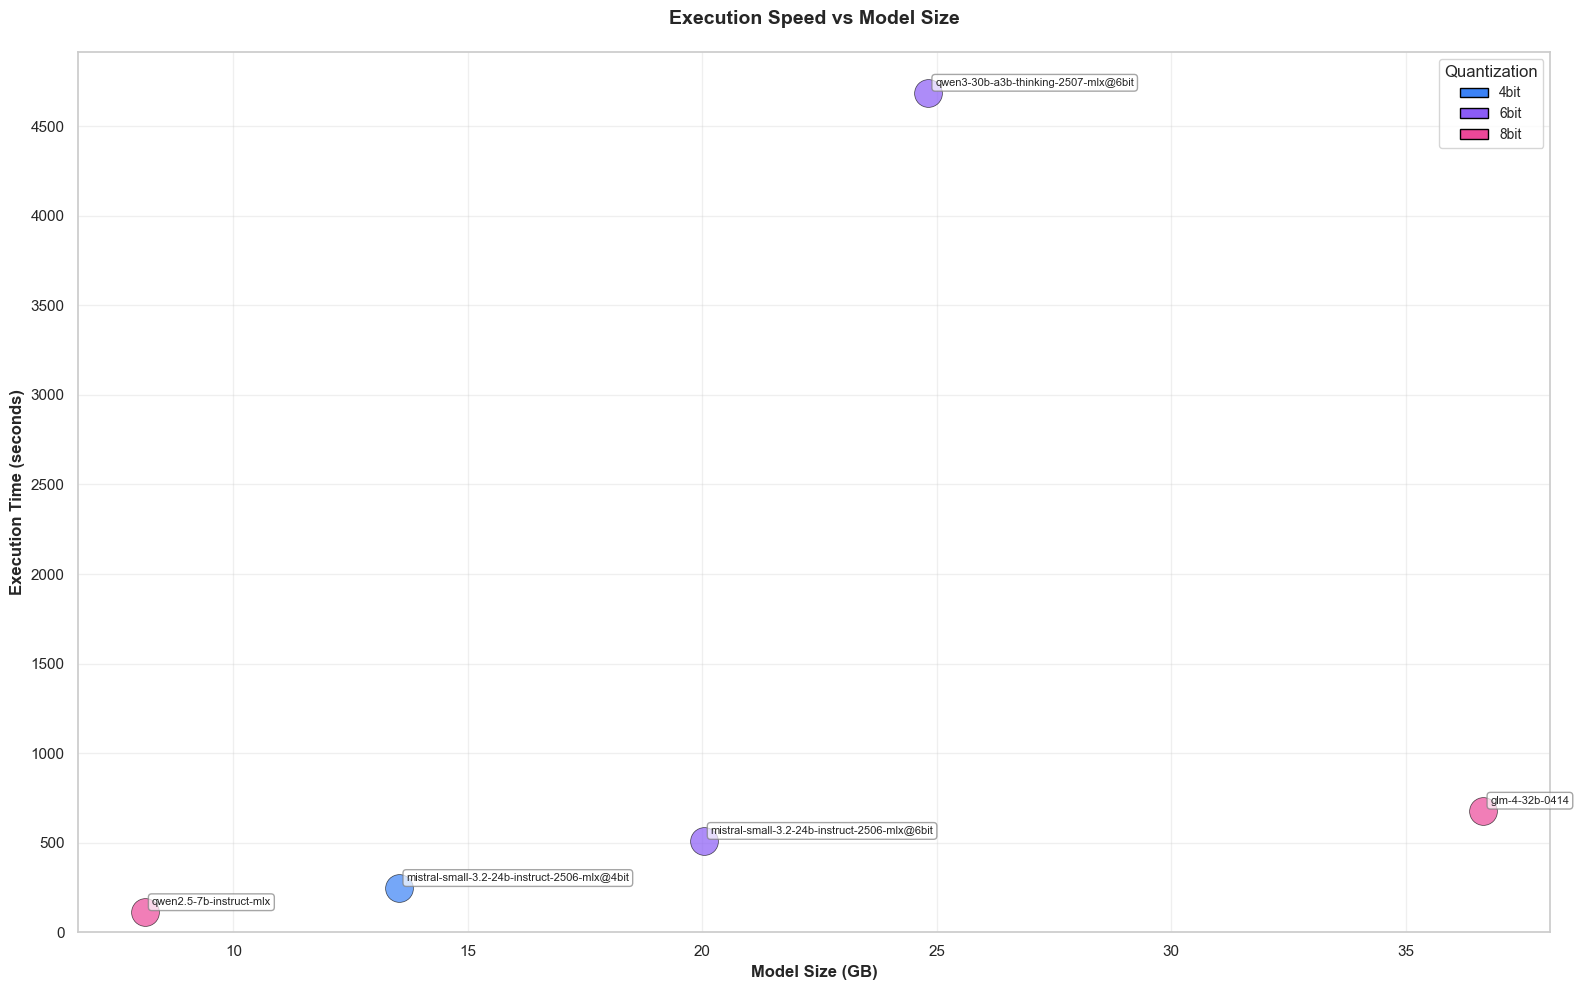

  ✓ Saved: shell_script_classification_06b_speed_vs_size.jpg


In [14]:
if (metrics_df["Params_B"] != "").any() and (metrics_df["Time_s"] > 0).any():
    print("Generating Visualization 6a: Speed vs Model Parameters...")

    df = metrics_df[
        (metrics_df["Params_B"] != "") &
        (metrics_df["Quantization"] != "") &
        (metrics_df["Time_s"] > 0)
    ].copy()

    if len(df) >= 2:
        df["Params_B"] = pd.to_numeric(df["Params_B"])

        quant_colors = {
            "4bit": "#3b82f6",
            "6bit": "#8b5cf6",
            "8bit": "#ec4899",
        }

        fig, ax = plt.subplots(figsize=FIGSIZE_LARGE)

        for quant in sorted(df["Quantization"].unique()):
            subset = df[df["Quantization"] == quant]
            ax.scatter(
                subset["Params_B"],
                subset["Time_s"],
                s=400,
                color=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                alpha=0.7,
                edgecolors="black",
                linewidth=0.5,
                label=quant
            )

        for _, row in df.iterrows():
            ax.annotate(
                row["Model"],
                (row["Params_B"], row["Time_s"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray")
            )

        ax.set_xlabel("Model Parameters (Billions)", fontweight="bold", fontsize=12)
        ax.set_ylabel("Execution Time (seconds)", fontweight="bold", fontsize=12)
        ax.set_title("Execution Speed vs Model Parameters", fontweight="bold", fontsize=14, pad=20)

        # Set y-axis to show whole numbers without scientific notation
        from matplotlib.ticker import ScalarFormatter, MaxNLocator
        ax.yaxis.set_major_locator(MaxNLocator(nbins=10, integer=False))
        formatter = ScalarFormatter(useOffset=False)
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)

        # Set y-axis to start from 0
        ax.set_ylim(bottom=0)

        ax.grid(alpha=0.3)

        # Create custom legend with rectangles instead of circles
        legend_elements = [
            Patch(facecolor=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                  edgecolor='black', linewidth=1, label=quant)
            for quant in sorted(df["Quantization"].unique())
        ]
        ax.legend(handles=legend_elements, title="Quantization", loc="best", fontsize=10)

        plt.tight_layout()

        output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}06a_speed_vs_params.jpg"
        plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
        plt.show()
        plt.close()
        print(f"  ✓ Saved: {output_path.name}")

        # Visualization 6b: Speed vs Size
        print("Generating Visualization 6b: Speed vs Model Size...")

        df = metrics_df[
            (metrics_df["Size_GB"] != "") &
            (metrics_df["Quantization"] != "") &
            (metrics_df["Time_s"] > 0)
        ].copy()

        if len(df) >= 2:
            df["Size_GB"] = pd.to_numeric(df["Size_GB"])

            fig, ax = plt.subplots(figsize=FIGSIZE_LARGE)

            for quant in sorted(df["Quantization"].unique()):
                subset = df[df["Quantization"] == quant]
                ax.scatter(
                    subset["Size_GB"],
                    subset["Time_s"],
                    s=400,
                    color=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                    alpha=0.7,
                    edgecolors="black",
                    linewidth=0.5,
                    label=quant
                )

            for _, row in df.iterrows():
                ax.annotate(
                    row["Model"],
                    (row["Size_GB"], row["Time_s"]),
                    xytext=(5, 5),
                    textcoords="offset points",
                    fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7, edgecolor="gray")
                )

            ax.set_xlabel("Model Size (GB)", fontweight="bold", fontsize=12)
            ax.set_ylabel("Execution Time (seconds)", fontweight="bold", fontsize=12)
            ax.set_title("Execution Speed vs Model Size", fontweight="bold", fontsize=14, pad=20)

            # Set y-axis to show whole numbers without scientific notation
            ax.yaxis.set_major_locator(MaxNLocator(nbins=10, integer=False))
            formatter = ScalarFormatter(useOffset=False)
            formatter.set_scientific(False)
            ax.yaxis.set_major_formatter(formatter)

            # Set y-axis to start from 0
            ax.set_ylim(bottom=0)

            ax.grid(alpha=0.3)

            # Create custom legend with rectangles instead of circles
            legend_elements = [
                Patch(facecolor=quant_colors.get(quant, COLOR_PALETTE["primary"]),
                      edgecolor='black', linewidth=1, label=quant)
                for quant in sorted(df["Quantization"].unique())
            ]
            ax.legend(handles=legend_elements, title="Quantization", loc="best", fontsize=10)

            plt.tight_layout()

            output_path = OUTPUT_DIR / f"{IMAGE_PREFIX}06b_speed_vs_size.jpg"
            plt.savefig(output_path, bbox_inches="tight", dpi=JPEG_DPI)
            plt.show()
            plt.close()
            print(f"  ✓ Saved: {output_path.name}")
        else:
            print("  ⚠ Insufficient data for size speed analysis")
    else:
        print("  ⚠ Insufficient data for parameter speed analysis")
else:
    print("\n⚠ Skipping speed characteristic analysis - insufficient data")

## Section 7: Summary

Analysis complete! All visualizations have been generated and saved.

### Model Recommendations

Based on the analysis of the three key questions, here are the recommended models for different use cases:

In [15]:
print("\n" + "=" * 80)
print(f"✓ Analysis complete! All visualizations saved to: {OUTPUT_DIR}/")
print("=" * 80)
print("\nGenerated files:")
for output_file in sorted(OUTPUT_DIR.glob(f"{IMAGE_PREFIX}*.jpg")):
    print(f"  - {output_file.name}")
print()


✓ Analysis complete! All visualizations saved to: /Users/flo/Developer/github/agentic-news-generator.git/main/notebooks/shellscript_analyzer/gfx/

Generated files:
  - shell_script_classification_01_confusion_matrices_grid.jpg
  - shell_script_classification_02_misclassification_by_test.jpg
  - shell_script_classification_03a_heatmap_fail_tests.jpg
  - shell_script_classification_03b_heatmap_pass_tests.jpg
  - shell_script_classification_04_efficiency_scatter.jpg
  - shell_script_classification_05a_performance_vs_params.jpg
  - shell_script_classification_05b_performance_vs_size.jpg
  - shell_script_classification_06a_speed_vs_params.jpg
  - shell_script_classification_06b_speed_vs_size.jpg



In [16]:
# Calculate model recommendations based on different criteria

# Filter to models with complete data
complete_df = metrics_df[
    (metrics_df["Time_s"] > 0) & 
    (metrics_df["Params_B"] != "") & 
    (metrics_df["Size_GB"] != "")
].copy()

complete_df["Params_B"] = pd.to_numeric(complete_df["Params_B"])
complete_df["Size_GB"] = pd.to_numeric(complete_df["Size_GB"])

print("=" * 80)
print("MODEL RECOMMENDATIONS")
print("=" * 80)
print()

# 1. SPEED FIRST + ACCURACY SECOND
# Find models with F1 > 0.90, then pick fastest
high_accuracy_threshold = 0.90
speed_candidates = complete_df[complete_df["F1_Score"] >= high_accuracy_threshold].copy()

if len(speed_candidates) > 0:
    speed_pick = speed_candidates.nsmallest(1, "Time_s").iloc[0]
    print("1️⃣  SPEED FIRST (Fastest among accurate models, F1 ≥ 0.90)")
    print("-" * 80)
    print(f"   Model: {speed_pick['Model']}")
    print(f"   F1 Score: {speed_pick['F1_Score']:.3f}")
    print(f"   Time: {speed_pick['Time_s']:.0f}s ({speed_pick['Time_s']/60:.1f} min)")
    print(f"   Size: {speed_pick['Size_GB']:.1f} GB")
    print(f"   Why: Fastest execution time while maintaining excellent accuracy")
    print()
else:
    print("1️⃣  SPEED FIRST: No models found with F1 ≥ 0.90")
    print()

# 2. ACCURACY OVER SPEED
# Pick highest F1 score regardless of time
accuracy_pick = complete_df.nlargest(1, "F1_Score").iloc[0]
print("2️⃣  ACCURACY FIRST (Best F1 score, speed not a concern)")
print("-" * 80)
print(f"   Model: {accuracy_pick['Model']}")
print(f"   F1 Score: {accuracy_pick['F1_Score']:.3f}")
print(f"   Time: {accuracy_pick['Time_s']:.0f}s ({accuracy_pick['Time_s']/60:.1f} min)")
print(f"   Size: {accuracy_pick['Size_GB']:.1f} GB")
print(f"   Why: Highest accuracy, {(accuracy_pick['Time_s']/60):.1f} min acceptable for best results")
print()

# 3. SIZE VS ACCURACY
# Calculate F1 per GB metric, pick best
complete_df["F1_per_GB"] = complete_df["F1_Score"] / complete_df["Size_GB"]
size_pick = complete_df.nlargest(1, "F1_per_GB").iloc[0]
print("3️⃣  SIZE EFFICIENCY (Best accuracy per GB)")
print("-" * 80)
print(f"   Model: {size_pick['Model']}")
print(f"   F1 Score: {size_pick['F1_Score']:.3f}")
print(f"   Size: {size_pick['Size_GB']:.1f} GB")
print(f"   Time: {size_pick['Time_s']:.0f}s ({size_pick['Time_s']/60:.1f} min)")
print(f"   Efficiency: {size_pick['F1_per_GB']:.4f} F1/GB")
print(f"   Why: Best performance-to-size ratio for storage-constrained environments")
print()

# 4. OVERALL BALANCED (Top 3)
# Use Pareto front models, or create balanced score
pareto_models = calculate_pareto_front(complete_df)

if len(pareto_models) >= 3:
    # If we have enough Pareto models, pick top 3 by F1
    balanced_picks = complete_df[complete_df["Model"].isin(pareto_models)].nlargest(3, "F1_Score")
    print("4️⃣  BALANCED MODELS (Top 3 on Pareto frontier)")
else:
    # Create a balanced score: normalize F1 (higher is better) and Time (lower is better)
    complete_df["F1_normalized"] = (complete_df["F1_Score"] - complete_df["F1_Score"].min()) / (complete_df["F1_Score"].max() - complete_df["F1_Score"].min())
    complete_df["Time_normalized"] = 1 - ((complete_df["Time_s"] - complete_df["Time_s"].min()) / (complete_df["Time_s"].max() - complete_df["Time_s"].min()))
    complete_df["Balanced_Score"] = (complete_df["F1_normalized"] * 0.6) + (complete_df["Time_normalized"] * 0.4)
    balanced_picks = complete_df.nlargest(3, "Balanced_Score")
    print("4️⃣  BALANCED MODELS (Top 3 by weighted score: 60% accuracy, 40% speed)")

print("-" * 80)
for idx, (_, row) in enumerate(balanced_picks.iterrows(), 1):
    print(f"   #{idx}: {row['Model']}")
    print(f"        F1: {row['F1_Score']:.3f} | Time: {row['Time_s']:.0f}s | Size: {row['Size_GB']:.1f} GB")
print()
print(f"   Why: Best trade-off between accuracy and speed")
print()

print("=" * 80)
print()

MODEL RECOMMENDATIONS

1️⃣  SPEED FIRST (Fastest among accurate models, F1 ≥ 0.90)
--------------------------------------------------------------------------------
   Model: mistral-small-3.2-24b-instruct-2506-mlx@4bit
   F1 Score: 0.970
   Time: 247s (4.1 min)
   Size: 13.5 GB
   Why: Fastest execution time while maintaining excellent accuracy

2️⃣  ACCURACY FIRST (Best F1 score, speed not a concern)
--------------------------------------------------------------------------------
   Model: qwen3-30b-a3b-thinking-2507-mlx@6bit
   F1 Score: 0.980
   Time: 4687s (78.1 min)
   Size: 24.8 GB
   Why: Highest accuracy, 78.1 min acceptable for best results

3️⃣  SIZE EFFICIENCY (Best accuracy per GB)
--------------------------------------------------------------------------------
   Model: qwen2.5-7b-instruct-mlx
   F1 Score: 0.840
   Size: 8.1 GB
   Time: 112s (1.9 min)
   Efficiency: 0.1036 F1/GB
   Why: Best performance-to-size ratio for storage-constrained environments

4️⃣  BALANCED MODE